In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
import tensorflow_datasets as tfds
import cv2
from tf_explain.core.grad_cam import GradCAM
from tf_explain.core.integrated_gradients import IntegratedGradients


In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True,
)

# Get the class labels
class_labels = ds_info.features['label'].names

# Print the class labels
print("Class labels:", class_labels)

Class labels: ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


2024-07-19 09:36:03.333250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


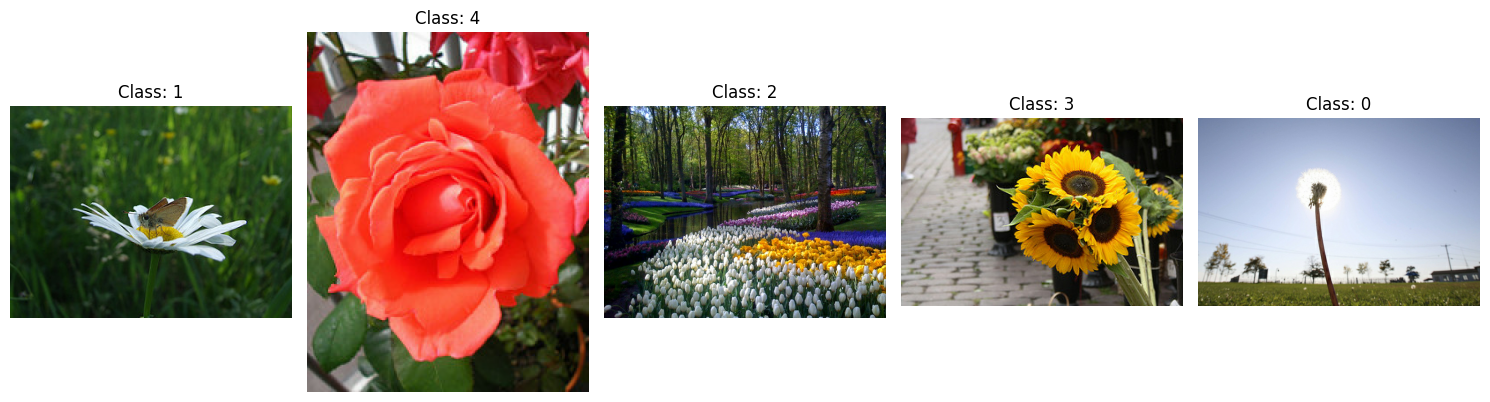

In [3]:
# Function to plot and save images
def plot_images(dataset, num_images, filename):
    plt.figure(figsize=(10, 6))
    for i, (image, label) in enumerate(dataset.take(num_images)):
        ax = plt.subplot(1, 5, i + 1)  # Adjust subplot layout for 5 images (2 rows, 3 columns)
        plt.imshow(image.numpy())
        plt.title(f"Label: {label.numpy()}")
        plt.axis("off")
    plt.tight_layout()  # Ensures tight layout to prevent overlapping
    plt.savefig(filename)
    plt.show()

# Plot the first 5 images from the training dataset and save to a file
#plot_images(train_ds, 5, 'Flowers_Dataset_5.png')


# Function to plot one randomly chosen image from each class
def plot_one_random_image_per_class(dataset):
    # Initialize empty lists to store one image from each class
    images_per_class = []
    labels_per_class = []

    # Convert dataset to list for easier indexing
    dataset_list = list(dataset)

    # Shuffle the dataset to randomly select images
    np.random.shuffle(dataset_list)

    # Iterate through the shuffled dataset to find one image from each class
    for image, label in dataset_list:
        if label.numpy() not in labels_per_class:
            images_per_class.append(image.numpy())
            labels_per_class.append(label.numpy())
            if len(images_per_class) == 5:  # Assuming 5 classes
                break

    # Plotting images
    plt.figure(figsize=(15, 8))
    for i in range(len(images_per_class)):
        plt.subplot(1, 5, i + 1)
        plt.imshow(images_per_class[i])
        plt.title(f"Class: {labels_per_class[i]}")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig('Flowers_Dataset5.png')
    plt.show()

# Assuming you have a dataset 'train_ds' that contains images and labels
plot_one_random_image_per_class(train_ds)

In [4]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize to [0,1]
    return image, label
    
train_ds = train_ds.map(lambda image, label: (data_augmentation(image), label))
train_ds = train_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image).batch(32).prefetch(tf.data.AUTOTUNE)


In [5]:
def build_and_train_model(train_ds, test_ds):

    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu',padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu',padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu',padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Flatten()(x)

    x = layers.Dropout(0.2)(x)

    x = layers.Dense(64, activation='relu')(x)
    
    outputs = layers.Dense(5)(x)  # 5 classes in the flowers dataset

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    model.fit(train_ds, epochs=10, validation_data=test_ds)
    return model

model = build_and_train_model(train_ds, test_ds)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.3120 - loss: 1.6195 - val_accuracy: 0.5327 - val_loss: 1.1184
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.5524 - loss: 1.1004 - val_accuracy: 0.6226 - val_loss: 0.9848
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6049 - loss: 0.9880 - val_accuracy: 0.6444 - val_loss: 0.9369
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.6414 - loss: 0.9223 - val_accuracy: 0.6553 - val_loss: 0.8769
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.6516 - loss: 0.8914 - val_accuracy: 0.6676 - val_loss: 0.8503
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.6721 - loss: 0.8494 - val_accuracy: 0.6975 - val_loss: 0.7995
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.6805 - loss: 0.8162 - val_accuracy: 0.7112 - val_loss: 0.7707
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.6915 - loss: 0.8028 - val_accuracy: 0.7112 - v

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,211,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,803,921 (37.40 MB)

 Trainable params: 3,267,973 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,535,948 (24.93 MB)

LIME Explanation:


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━

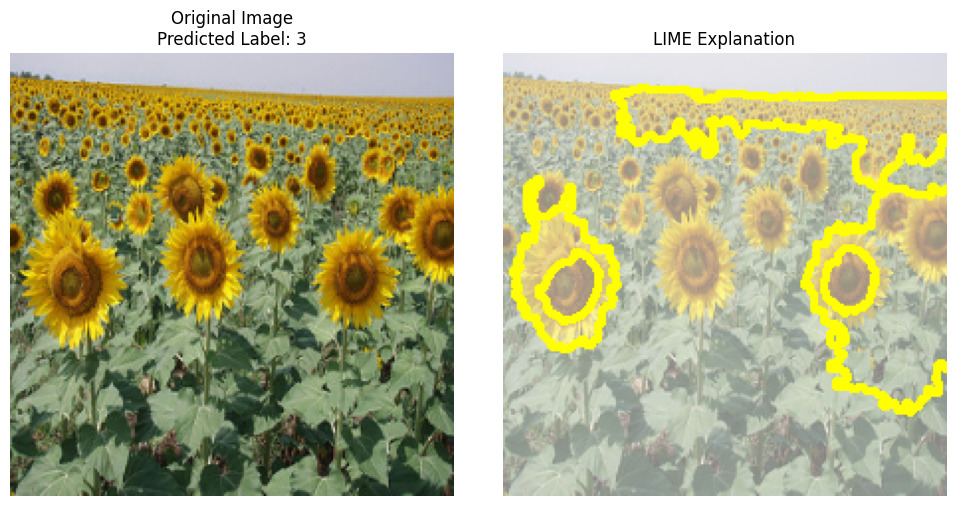

In [7]:
def explain_with_lime(model, image):
    explainer = lime_image.LimeImageExplainer()

    def segmentation_fn(image):
        return slic(image, n_segments=50, compactness=10, sigma=1)

    def predict_fn(images):
        return model.predict(images)

    explanation = explainer.explain_instance(
        image.astype('double'),
        predict_fn,
        top_labels=1,
        hide_color=0,
        num_samples=1000,
        segmentation_fn=segmentation_fn
    )

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=5,
        hide_rest=False
    )

    img_with_border = mark_boundaries(temp / 2 + 0.5, mask, mode='thin', outline_color=(1, 1, 0))
    
    # Plot original image and LIME explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Predict the label for the image
    predicted_label = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    # Plot original image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title(f'Original Image\nPredicted Label: {predicted_label}')

    # Plot LIME explanation
    axes[1].imshow(img_with_border)
    axes[1].axis('off')
    axes[1].set_title('LIME Explanation')

    plt.tight_layout()
     # Save the figure
    plt.savefig('LIME_Explaination9.png')
    plt.show()

# Get a sample image from the test set
for image, label in test_ds.take(1):
    sample_image = image.numpy()
    label_image = image.numpy()
    break

print("LIME Explanation:")
explain_with_lime(model, sample_image[9])


Integrated Gradients Explanation:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


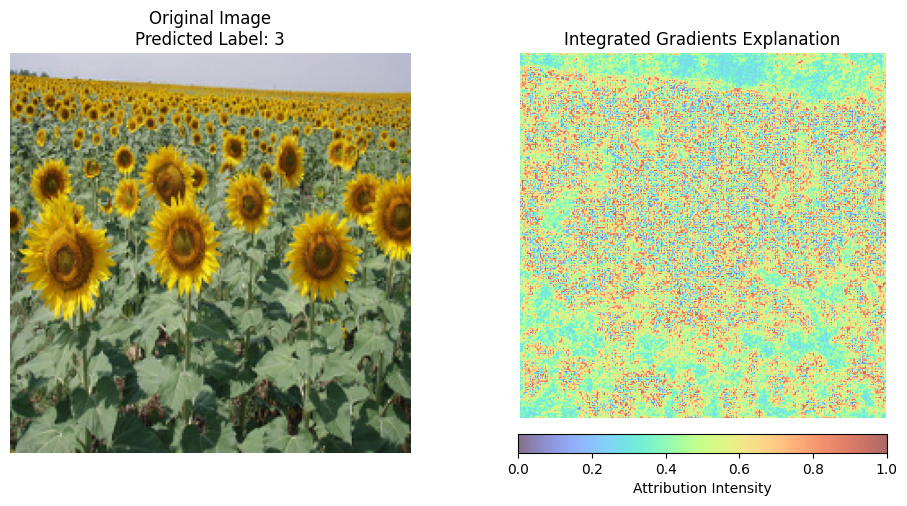

In [8]:
def explain_with_integrated_gradients(model, image, label, n_steps=50):
    ig = IntegratedGradients()
    data = ([image], None)
    explanation = ig.explain(data, model, class_index=label, n_steps=n_steps)

    # Normalize the explanation to [0, 1]
    explanation = np.abs(explanation)
    explanation = np.squeeze(explanation)
    explanation = (explanation - np.min(explanation)) / (np.max(explanation) - np.min(explanation))

    # Predict the label and its confidence for the image
    predicted_probabilities = model.predict(np.expand_dims(image, axis=0))
    predicted_label = np.argmax(predicted_probabilities)
    confidence = np.max(predicted_probabilities)

    # Plot original image and explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot original image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title(f'Original Image\nPredicted Label: {predicted_label}')

    # Plot explanation
    im = axes[1].imshow(explanation, cmap='turbo', alpha=0.6)  # Adjust the colormap for better visibility
    axes[1].axis('off')
    axes[1].set_title('Integrated Gradients Explanation')

    # Add a color bar for the explanation
    cbar = fig.colorbar(im, ax=axes[1], orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Attribution Intensity')
    
    plt.tight_layout()
    plt.savefig('Integrated Gradients_Explaination9.png')
    plt.show()

print("Integrated Gradients Explanation:")
explain_with_integrated_gradients(model, sample_image[9], label[9], n_steps=100)


Grad-CAM Explanation:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


Probabilities after softmax:
[[2.0768045e-02 3.7368943e-04 7.7245128e-03 9.7105128e-01 8.2400096e-05]]


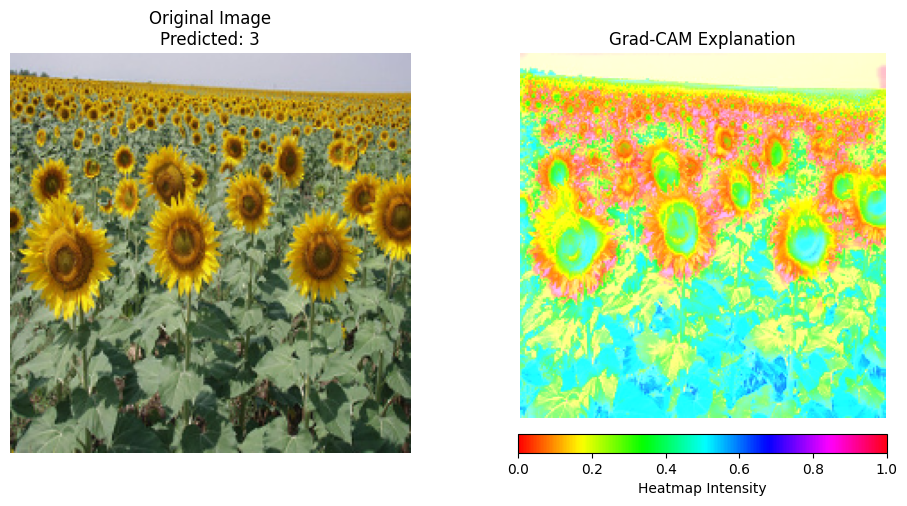

In [10]:
def explain_with_gradcam(model, image, label):
    gradcam = GradCAM()
    data = ([image], None)
    explanation = gradcam.explain(data, model, class_index=label, layer_name='conv2d_2')

    # Get model prediction
    pred = model.predict(np.expand_dims(image, axis=0))

    pred_label = np.argmax(pred[0])
    pred_confidence = np.max(pred[0])

    probabilities = tf.nn.softmax(pred).numpy()

    print("Probabilities after softmax:")
    print(probabilities)
    
    # Plot original image and Grad-CAM explanation side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Plot original image
    axes[0].imshow(image)
    axes[0].axis('off')
    axes[0].set_title(f'Original Image\nPredicted: {pred_label}')

    # Apply Grad-CAM heatmap on original image
    heatmap = np.uint8(explanation)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.004 + image

    # Plot Grad-CAM explanation
    im = axes[1].imshow(superimposed_img)
    axes[1].axis('off')
    axes[1].set_title('Grad-CAM Explanation')

    # Add a color bar for the heatmap
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='hsv'), ax=axes[1], orientation='horizontal', fraction=0.046, pad=0.04)
    cbar.set_label('Heatmap Intensity')

    plt.tight_layout()
    plt.savefig('Grad-CAM_Explaination9.png')
    plt.show()

print("Grad-CAM Explanation:")

explain_with_gradcam(model, sample_image[9], label[9])
